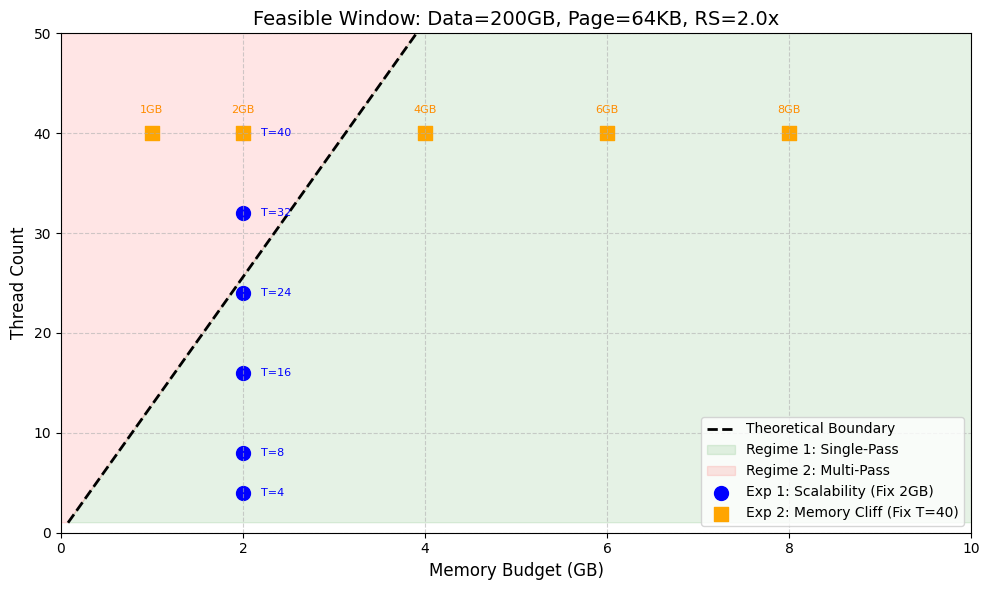


EXPERIMENT 2: MEMORY CLIFF (Fixed Threads = 40)
Updated Calculation: Runs = Data / (Buffer * 2.0)


,Mem (GB),Buffer (MB),Eff. Run (MB),Est. Runs,Max Fan-In,Regime
0,8,204.8,409.6,500,3276,SAFE (Regime 1)
1,6,153.6,307.2,666,2457,SAFE (Regime 1)
2,4,102.4,204.8,1000,1638,SAFE (Regime 1)
3,2,51.2,102.4,2000,819,FAIL (Regime 2)
4,1,25.6,51.2,4000,409,FAIL (Regime 2)


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# ==========================================
# 1. SYSTEM & DATA CONFIGURATION
# ==========================================
DATA_SIZE_GB = 200        # Input Data Size (GB)
PAGE_SIZE_KB = 64         # Page Size (KB)
RS_FACTOR = 2.0           # Replacement Selection Factor (2.0 = 2x Memory)

# Constants for Math
D_bytes = DATA_SIZE_GB * 1024**3
P_bytes = PAGE_SIZE_KB * 1024

# ==========================================
# 2. THEORETICAL MODEL FUNCTIONS
# ==========================================
def get_min_memory_for_threads(t):
    """Returns minimal memory (GB) needed for single-pass merge with T threads."""
    # M >= T * sqrt(D * P) / sqrt(2)
    m_bytes = t * math.sqrt(D_bytes * P_bytes) / math.sqrt(RS_FACTOR)
    return m_bytes / 1024**3

def get_max_feasible_fanin(mem_gb, threads):
    """
    Calculates the physical limit of runs we can merge in one pass.
    Formula: FanIn <= Total_Memory / (Threads * PageSize)
    """
    mem_bytes = mem_gb * 1024**3
    max_fanin = mem_bytes / (threads * P_bytes)
    return int(max_fanin)

def get_regime_status(mem_gb, threads):
    """Determines stats and Regime status."""
    # 1. Calculate Buffer Size per Thread (This is --run-size-mb)
    buffer_size_mb = (mem_gb * 1024) / threads
    
    # 2. Calculate Effective Run Size (Output Size)
    # Replacement Selection produces runs ~2x the buffer size
    effective_run_size_mb = buffer_size_mb * RS_FACTOR
    
    # 3. Calculate Actual Runs Generated
    num_runs = (DATA_SIZE_GB * 1024) / effective_run_size_mb
    
    # 4. Calculate Max Feasible Fan-In (Physical Limit)
    max_fanin = get_max_feasible_fanin(mem_gb, threads)
    
    # 5. Determine Regime
    if num_runs <= max_fanin:
        status = "SAFE (Regime 1)"
    else:
        status = "FAIL (Regime 2)"
        
    return buffer_size_mb, effective_run_size_mb, num_runs, max_fanin, status

# ==========================================
# 3. PLOTTING (Same as before)
# ==========================================
threads_y = np.linspace(1, 64, 100)
memory_x_curve = [get_min_memory_for_threads(t) for t in threads_y]

exp1_mem = 2
exp1_threads = [4, 8, 16, 24, 32, 40]
exp1_y = exp1_threads
exp1_x = [exp1_mem] * len(exp1_threads)

exp2_threads = 40
exp2_mem = [8, 6, 4, 2, 1]
exp2_x = exp2_mem
exp2_y = [exp2_threads] * len(exp2_mem)

plt.figure(figsize=(10, 6))
plt.plot(memory_x_curve, threads_y, 'k--', linewidth=2, label='Theoretical Boundary')
plt.fill_betweenx(threads_y, memory_x_curve, 35, color='green', alpha=0.1, label='Regime 1: Single-Pass')
plt.fill_betweenx(threads_y, 0, memory_x_curve, color='red', alpha=0.1, label='Regime 2: Multi-Pass')

plt.scatter(exp1_x, exp1_y, color='blue', s=100, marker='o', label=f'Exp 1: Scalability (Fix {exp1_mem}GB)')
for t in exp1_threads:
    plt.text(exp1_mem + 0.2, t, f"T={t}", fontsize=8, color='blue', va='center')

plt.scatter(exp2_x, exp2_y, color='orange', s=100, marker='s', label=f'Exp 2: Memory Cliff (Fix T={exp2_threads})')
for m in exp2_mem:
    plt.text(m, exp2_threads + 2, f"{m}GB", fontsize=8, color='darkorange', ha='center')

plt.title(f"Feasible Window: Data={DATA_SIZE_GB}GB, Page={PAGE_SIZE_KB}KB, RS={RS_FACTOR}x", fontsize=14)
plt.xlabel("Memory Budget (GB)", fontsize=12)
plt.ylabel("Thread Count", fontsize=12)
plt.xlim(0, 10)
plt.ylim(0, 50)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# ==========================================
# 4. GENERATE DATA TABLES
# ==========================================

print(f"\nEXPERIMENT 2: MEMORY CLIFF (Fixed Threads = {exp2_threads})")
print("Updated Calculation: Runs = Data / (Buffer * 2.0)")
print("="*80)

exp2_data = []
for m in exp2_mem:
    buf_mb, eff_run_mb, n_runs, max_fan, status = get_regime_status(m, exp2_threads)
    
    exp2_data.append({
        "Mem (GB)": m,
        "Buffer (MB)": f"{buf_mb:.1f}",
        "Eff. Run (MB)": f"{eff_run_mb:.1f}",
        "Est. Runs": int(n_runs),
        "Max Fan-In": max_fan,
        "Regime": status
    })

df2 = pd.DataFrame(exp2_data)
display(df2)

In [23]:
import pandas as pd
import math

# --- CONFIGURATION ---
DATA_SIZE_GB = 200
PAGE_SIZE_KB = 64
RS_FACTOR = 2.0
EXP1_MEM_GB = 2  # Fixed Memory for this experiment

# --- LOGIC ---
def get_status(mem_gb, threads):
    # 1. Buffer Size (Physical RAM per thread)
    buffer_mb = (mem_gb * 1024) / threads
    
    # 2. Effective Run Size (Output size after Replacement Selection)
    #    (Buffer * 2.0)
    eff_run_mb = buffer_mb * RS_FACTOR
    
    # 3. Estimated Number of Runs
    #    Total Data / Effective Run Size
    num_runs = (DATA_SIZE_GB * 1024) / eff_run_mb
    
    # 4. Max Feasible Fan-In (Physical Limit)
    #    Memory / (Threads * PageSize)
    #    (Convert GB to Bytes / Threads * KB to Bytes)
    max_fanin = (mem_gb * 1024**3) / (threads * PAGE_SIZE_KB * 1024)
    
    # 5. Regime Check
    if num_runs <= max_fanin:
        status = "SAFE (Regime 1)"
    else:
        status = "FAIL (Regime 2)"
        
    return buffer_mb, eff_run_mb, int(num_runs), int(max_fanin), status

# --- GENERATE TABLE ---
threads_to_test = [4, 8, 16, 24, 32, 40]
data = []

for t in threads_to_test:
    buf, run, n_runs, max_fan, stat = get_status(EXP1_MEM_GB, t)
    data.append({
        "Threads": t,
        "Buffer (MB)": f"{buf:.1f}",
        "Eff. Run (MB)": f"{run:.1f}",
        "Est. Runs": n_runs,
        "Max Fan-In": max_fan,
        "Regime": stat
    })

print(f"EXPERIMENT 1: SCALABILITY TRAP (Fixed Memory = {EXP1_MEM_GB} GB)")
display(pd.DataFrame(data))

EXPERIMENT 1: SCALABILITY TRAP (Fixed Memory = 2 GB)


,Threads,Buffer (MB),Eff. Run (MB),Est. Runs,Max Fan-In,Regime
0,4,512.0,1024.0,200,8192,SAFE (Regime 1)
1,8,256.0,512.0,400,4096,SAFE (Regime 1)
2,16,128.0,256.0,800,2048,SAFE (Regime 1)
3,24,85.3,170.7,1200,1365,SAFE (Regime 1)
4,32,64.0,128.0,1600,1024,FAIL (Regime 2)
5,40,51.2,102.4,2000,819,FAIL (Regime 2)
